In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

In [53]:
# All of these are potentially useful, though
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<AxesSubplot:>

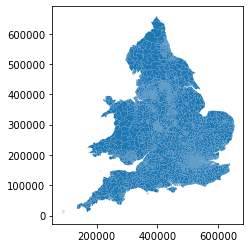

In [2]:
#loading the MSOAs for England and Wales

msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

In [3]:
msoas.sample(3)

OBJECTID   MSOA11CD                       MSOA11NM  \
3753      3754  E02003848  Cheshire West and Chester 010   
5088      5089  E02005203                      Fylde 001   
4929      4930  E02005039                   Dartford 012   

                          MSOA11NMW   BNG_E   BNG_N      LONG       LAT  \
3753  Cheshire West and Chester 010  339033  375429 -2.915660  53.27234   
5088                      Fylde 001  338588  435826 -2.934210  53.81508   
4929                   Dartford 012  557517  170842  0.263759  51.41471   

        Shape__Are    Shape__Len  \
3753  1.178243e+06   7827.532139   
5088  6.612758e+07  52819.521257   
4929  1.315892e+07  24037.361442   

                                               geometry  
3753  POLYGON ((338998.906 376436.860, 339042.534 37...  
5088  POLYGON ((340993.503 440973.802, 341160.902 44...  
4929  POLYGON ((559076.625 172884.797, 559383.500 17...

In [4]:
msoas.shape


(7201, 11)

In [5]:
msoas_england = msoas[msoas.MSOA11CD.str.startswith('E')]

In [6]:
msoas_england.head()

OBJECTID   MSOA11CD                  MSOA11NM                 MSOA11NMW  \
0         1  E02000001        City of London 001        City of London 001   
1         2  E02000002  Barking and Dagenham 001  Barking and Dagenham 001   
2         3  E02000003  Barking and Dagenham 002  Barking and Dagenham 002   
3         4  E02000004  Barking and Dagenham 003  Barking and Dagenham 003   
4         5  E02000005  Barking and Dagenham 004  Barking and Dagenham 004   

    BNG_E   BNG_N      LONG       LAT    Shape__Are   Shape__Len  \
0  532384  181355 -0.093490  51.51561  2.906361e+06  8936.818478   
1  548267  189685  0.138756  51.58652  2.166163e+06  8150.405928   
2  548259  188520  0.138149  51.57605  2.143568e+06  9118.196243   
3  551004  186412  0.176828  51.55638  2.491467e+06  8206.551627   
4  548733  186824  0.144267  51.56069  1.186053e+06  6949.688798   

                                            geometry  
0  POLYGON ((532135.138 182198.131, 532158.250 18...  
1  POLYGON ((548881.563 190845.265, 548881.125 19...  
2  POLYGON ((549102.438 189324.625, 548954.517 18...  
3  POLYGON ((551550.056 187364.705, 551478.000 18...  
4  POLYGON ((549099.634 187656.076, 549161.375 18...

In [7]:
msoas_england.shape

(6791, 11)

In [8]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len']
msoas_england.drop(columns=to_drop, inplace = True)
print(msoas_england.shape)

(6791, 6)


/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
msoas_england.head()

OBJECTID   MSOA11CD                  MSOA11NM   BNG_E   BNG_N  \
0         1  E02000001        City of London 001  532384  181355   
1         2  E02000002  Barking and Dagenham 001  548267  189685   
2         3  E02000003  Barking and Dagenham 002  548259  188520   
3         4  E02000004  Barking and Dagenham 003  551004  186412   
4         5  E02000005  Barking and Dagenham 004  548733  186824   

                                            geometry  
0  POLYGON ((532135.138 182198.131, 532158.250 18...  
1  POLYGON ((548881.563 190845.265, 548881.125 19...  
2  POLYGON ((549102.438 189324.625, 548954.517 18...  
3  POLYGON ((551550.056 187364.705, 551478.000 18...  
4  POLYGON ((549099.634 187656.076, 549161.375 18...

In [10]:
msoas_england['borough'] = msoas_england.MSOA11NM.str.replace(r' \d+','',regex=True)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
#### Add MSOA Names using a Merge

#The House of Commons Library provides a [MSOA Names](https://visual.parliament.uk/msoanames) data set that contains locally-relevant names applied to MSOAs. 
#These seek to connect the Census geography (OA > LSOA > MSOA > LA) to a loosely-defined 'neighbourhood'.

In [12]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')

In [13]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


msoa11cd        msoa11nm      msoa11nmw              msoa11hclnm  \
4512  E02005951      Oxford 012     Oxford 012  Grandpont & New Hinksey   
4660  W02000113       Powys 017      Powys 017                   Brecon   
1038  W02000309  Caerphilly 020  Caerffili 020       Bedwas & Trethomas   

            msoa11hclnmw      Laname  
4512                 NaN      Oxford  
4660          Aberhonddu       Powys  
1038  Bedwas a Thretomas  Caerphilly

In [14]:
msoas = pd.merge(msoas_england, msoa_nms, how = 'inner' , left_on = 'MSOA11CD', right_on = 'msoa11cd')
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(6791, 13)
<class 'geopandas.geodataframe.GeoDataFrame'>


OBJECTID   MSOA11CD     MSOA11NM               msoa11hclnm
3142      3143  E02003230  Swindon 019  Central South & Eastcott
3076      3077  E02003161   Torbay 008           Torquay Central
101        102  E02000104    Brent 012             Wembley North

In [15]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry',
       'borough', 'msoa11cd', 'msoa11nm', 'msoa11nmw', 'msoa11hclnm',
       'msoa11hclnmw', 'Laname'],
      dtype='object')

In [16]:
# tidy up
to_drop = ['msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(6791, 8)


In [17]:
msoas.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'BNG_E', 'BNG_N', 'geometry',
       'borough', 'msoa11hclnm'],
      dtype='object')

In [18]:
# SAVE

msoas.to_file(os.path.join('data','England_MSOAs.gpkg'), driver='GPKG')

In [19]:
####### #going to read in the Public Health England deaths csv


In [20]:
#first need to check current directory
os.getcwd()

'/home/jovyan/work/Modules/spatial_data_capture/project'

In [21]:
deaths = pd.read_csv('data/preventable_deaths_phe.csv')

In [22]:
deaths.head()

Code                     Label  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable\r\nlower confidence limit  \
0                                               49.9                     
1                                               68.3                     
2                                               79.8                     
3                                               83.4                     
4                                               79.1                     

   Deaths from causes considered preventable  \
0                                       68.5   
1                                       93.6   
2                                      101.8   
3                                      110.7   
4                                      103.9   

   Deaths from causes considered preventable\r\nupper confidence limit  
0                                               91.6                    
1                                              125.2                    
2                                              128.0                    
3                                              144.0                    
4                                              134.0

In [23]:
deaths = deaths[['Code', 'Label', 'Deaths from causes considered preventable']]

In [24]:
deaths.head()

Code                     Label  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable  
0                                       68.5  
1                                       93.6  
2                                      101.8  
3                                      110.7  
4                                      103.9

In [25]:
deaths.shape

(6791, 3)

In [26]:
pop_and_demo = pd.read_csv('data/community_data.csv')

In [27]:
pop_and_demo.head()

Code                     Label  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Black and Minority Ethnic Population\r\nlower confidence limit  \
0                                               20.4                
1                                               33.9                
2                                               44.4                
3                                               18.1                
4                                               32.7                

   Black and Minority Ethnic Population  \
0                                  21.4   
1                                  35.0   
2                                  45.4   
3                                  19.0   
4                                  33.7   

   Black and Minority Ethnic Population\r\nupper confidence limit  \
0                                               22.3                
1                                               36.2                
2                                               46.4                
3                                               20.0                
4                                               34.7                

   Long Term Unemployment\r\nlower confidence limit  Long Term Unemployment  \
0                                               1.8                     3.0   
1                                               5.2                     7.3   
2                                               2.5                     3.7   
3                                               5.7                     7.9   
4                                               3.0                     4.4   

   Long Term Unemployment\r\nupper confidence limit  \
0                                               4.9   
1                                              10.2   
2                                               5.4   
3                                              11.1   
4                                               6.3   

   Index of Multiple Deprivation (IMD) Score 2015  \
0                                            13.6   
1                                            38.5   
2                                            25.7   
3                                            24.8   
4                                            32.5   

   Proportion of households in poverty\r\nlower confidence limit  ...  \
0                                                8.1              ...   
1                                               21.3              ...   
2                                               16.0              ...   
3                                               16.4              ...   
4                                               17.0              ...   

   Population aged 16 to 24 years\r\nupper confidence limit  \
0                                                9.7          
1                                               11.3          
2                                               10.8          
3                                               14.2          
4                                               11.8          

   Population aged 25 to 64 years\r\nlower confidence limit  \
0                                               55.5          
1                                               47.2          
2                                               53.1          
3                                               49.2          
4                                               51.2          

   Population aged 25 to 64 years  \
0                            56.6   
1                            48.3   
2                            54.1   
3                            50.4   
4                            52.2   

   Population aged 25 to 64 years\r\nupper confidence limit  \
0                                               57.7      

In [28]:
pop_and_demo.shape

(6791, 27)

In [29]:
pop_and_demo.columns

Index(['Code', 'Label',
       'Black and Minority Ethnic Population\r\nlower confidence limit',
       'Black and Minority Ethnic Population',
       'Black and Minority Ethnic Population\r\nupper confidence limit',
       'Long Term Unemployment\r\nlower confidence limit',
       'Long Term Unemployment',
       'Long Term Unemployment\r\nupper confidence limit',
       'Index of Multiple Deprivation (IMD) Score 2015',
       'Proportion of households in poverty\r\nlower confidence limit',
       'Proportion of households in poverty',
       'Proportion of households in poverty\r\nupper confidence limit',
       'Population 0 to 15 years\r\nlower confidence limit',
       'Population 0 to 15 years',
       'Population 0 to 15 years\r\nupper confidence limit',
       'Population aged 16 to 24 years\r\nlower confidence limit',
       'Population aged 16 to 24 years',
       'Population aged 16 to 24 years\r\nupper confidence limit',
       'Population aged 25 to 64 years\r\nlower confi

In [30]:
to_keep = ['Code', 'Label', 'Black and Minority Ethnic Population', 'Long Term Unemployment', 'Index of Multiple Deprivation (IMD) Score 2015', 'Proportion of households in poverty', 'Population 0 to 15 years','Population aged 16 to 24 years', 'Population aged 25 to 64 years', 'Population aged 65 years and over', 'Population aged 85 years and over' ]

In [31]:
pop_and_demo = pop_and_demo[to_keep]
pop_and_demo.head()

Code                     Label  Black and Minority Ethnic Population  \
0  E02000001        City of London 001                                  21.4   
1  E02000002  Barking and Dagenham 001                                  35.0   
2  E02000003  Barking and Dagenham 002                                  45.4   
3  E02000004  Barking and Dagenham 003                                  19.0   
4  E02000005  Barking and Dagenham 004                                  33.7   

   Long Term Unemployment  Index of Multiple Deprivation (IMD) Score 2015  \
0                     3.0                                            13.6   
1                     7.3                                            38.5   
2                     3.7                                            25.7   
3                     7.9                                            24.8   
4                     4.4                                            32.5   

   Proportion of households in poverty  Population 0 to 15 years  \
0                                 15.5                      15.1   
1                                 28.1                      27.4   
2                                 21.6                      23.5   
3                                 22.2                      20.0   
4                                 23.1                      27.0   

   Population aged 16 to 24 years  Population aged 25 to 64 years  \
0                             9.0                            56.6   
1                            10.6                            48.3   
2                            10.2                            54.1   
3                            13.3                            50.4   
4                            11.2                            52.2   

   Population aged 65 years and over  Population aged 85 years and over  
0                               19.4                                2.6  
1                               13.7                                3.0  
2                               12.2                                1.9  
3                               16.3                                3.4  
4                                9.6                                1.4

In [32]:
variables = pd.merge(deaths, pop_and_demo, on = 'Code')
variables.head()

Code                   Label_x  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable                   Label_y  \
0                                       68.5        City of London 001   
1                                       93.6  Barking and Dagenham 001   
2                                      101.8  Barking and Dagenham 002   
3                                      110.7  Barking and Dagenham 003   
4                                      103.9  Barking and Dagenham 004   

   Black and Minority Ethnic Population  Long Term Unemployment  \
0                                  21.4                     3.0   
1                                  35.0                     7.3   
2                                  45.4                     3.7   
3                                  19.0                     7.9   
4                                  33.7                     4.4   

   Index of Multiple Deprivation (IMD) Score 2015  \
0                                            13.6   
1                                            38.5   
2                                            25.7   
3                                            24.8   
4                                            32.5   

   Proportion of households in poverty  Population 0 to 15 years  \
0                                 15.5                      15.1   
1                                 28.1                      27.4   
2                                 21.6                      23.5   
3                                 22.2                      20.0   
4                                 23.1                      27.0   

   Population aged 16 to 24 years  Population aged 25 to 64 years  \
0                             9.0                            56.6   
1                            10.6                            48.3   
2                            10.2                            54.1   
3                            13.3                            50.4   
4                            11.2                            52.2   

   Population aged 65 years and over  Population aged 85 years and over  
0                               19.4                                2.6  
1                               13.7                                3.0  
2                               12.2                                1.9  
3                               16.3                                3.4  
4                                9.6                                1.4

In [33]:
variables.drop(['Label_y'], axis = 1, inplace = True)
variables.head()

Code                   Label_x  \
0  E02000001        City of London 001   
1  E02000002  Barking and Dagenham 001   
2  E02000003  Barking and Dagenham 002   
3  E02000004  Barking and Dagenham 003   
4  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable  \
0                                       68.5   
1                                       93.6   
2                                      101.8   
3                                      110.7   
4                                      103.9   

   Black and Minority Ethnic Population  Long Term Unemployment  \
0                                  21.4                     3.0   
1                                  35.0                     7.3   
2                                  45.4                     3.7   
3                                  19.0                     7.9   
4                                  33.7                     4.4   

   Index of Multiple Deprivation (IMD) Score 2015  \
0                                            13.6   
1                                            38.5   
2                                            25.7   
3                                            24.8   
4                                            32.5   

   Proportion of households in poverty  Population 0 to 15 years  \
0                                 15.5                      15.1   
1                                 28.1                      27.4   
2                                 21.6                      23.5   
3                                 22.2                      20.0   
4                                 23.1                      27.0   

   Population aged 16 to 24 years  Population aged 25 to 64 years  \
0                             9.0                            56.6   
1                            10.6                            48.3   
2                            10.2                            54.1   
3                            13.3                            50.4   
4                            11.2                            52.2   

   Population aged 65 years and over  Population aged 85 years and over  
0                               19.4                                2.6  
1                               13.7                                3.0  
2                               12.2                                1.9  
3                               16.3                                3.4  
4                                9.6                                1.4

In [34]:
gdf = pd.merge(msoas, variables, left_on = 'MSOA11CD', right_on = 'Code', how = 'inner')

In [35]:
gdf.head()

OBJECTID   MSOA11CD                  MSOA11NM   BNG_E   BNG_N  \
0         1  E02000001        City of London 001  532384  181355   
1         2  E02000002  Barking and Dagenham 001  548267  189685   
2         3  E02000003  Barking and Dagenham 002  548259  188520   
3         4  E02000004  Barking and Dagenham 003  551004  186412   
4         5  E02000005  Barking and Dagenham 004  548733  186824   

                                            geometry               borough  \
0  POLYGON ((532135.138 182198.131, 532158.250 18...        City of London   
1  POLYGON ((548881.563 190845.265, 548881.125 19...  Barking and Dagenham   
2  POLYGON ((549102.438 189324.625, 548954.517 18...  Barking and Dagenham   
3  POLYGON ((551550.056 187364.705, 551478.000 18...  Barking and Dagenham   
4  POLYGON ((549099.634 187656.076, 549161.375 18...  Barking and Dagenham   

           msoa11hclnm       Code                   Label_x  \
0       City of London  E02000001        City of London 001   
1           Marks Gate  E02000002  Barking and Dagenham 001   
2  Chadwell Heath East  E02000003  Barking and Dagenham 002   
3         Eastbrookend  E02000004  Barking and Dagenham 003   
4      Becontree Heath  E02000005  Barking and Dagenham 004   

   Deaths from causes considered preventable  \
0                                       68.5   
1                                       93.6   
2                                      101.8   
3                                      110.7   
4                                      103.9   

   Black and Minority Ethnic Population  Long Term Unemployment  \
0                                  21.4                     3.0   
1                                  35.0                     7.3   
2                                  45.4                     3.7   
3                                  19.0                     7.9   
4                                  33.7                     4.4   

   Index of Multiple Deprivation (IMD) Score 2015  \
0                                            13.6   
1                                            38.5   
2                                            25.7   
3                                            24.8   
4                                            32.5   

   Proportion of households in poverty  Population 0 to 15 years  \
0                                 15.5                      15.1   
1                                 28.1                      27.4   
2                                 21.6                      23.5   
3                                 22.2                      20.0   
4                                 23.1                      27.0   

   Population aged 16 to 24 years  Population aged 25 to 64 years  \
0                             9.0                            56.6   
1                            10.6                            48.3   
2                            10.2                            54.1   
3                            13.3                            50.4   
4                            11.2                            52.2   

   Population aged 65 years and over  Population aged 85 years and over  
0                               19.4                                2.6  
1                               13.7                                3.0  
2                               12.2                                1.9  
3                               16.3                                3.4  
4                                9.6                                1.4

In [36]:
gdf = gdf.drop(columns=['MSOA11CD', 'Label_x']).rename(columns={'MSOA11NM': 'MSOA_name', 'Code': 'MSOA_code', 'Deaths from causes considered preventable' : 'preventable_deaths', 'Black and Minority Ethnic Population' : 'bame', 'Long Term Unemployment' : 'longterm_unemployed', 'Index of Multiple Deprivation (IMD) Score 2015' : 'imd_2015', 'Proportion of households in poverty' : 'household_poverty', 'Population 0 to 15 years' : 'pop_0_15', 'Population aged 16 to 24 years' : 'pop_16_24', 'Population aged 25 to 64 years' : 'pop_25_64', 'Population aged 65 years and over' : 'pop_above_65', 'Population aged 85 years and over' : 'pop_above_85' })

print(f"England MSOA preventable deaths and demographics data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

England MSOA preventable deaths and demographics data frame has shape 6,791 x 18


In [37]:
gdf.head()

OBJECTID                 MSOA_name   BNG_E   BNG_N  \
0         1        City of London 001  532384  181355   
1         2  Barking and Dagenham 001  548267  189685   
2         3  Barking and Dagenham 002  548259  188520   
3         4  Barking and Dagenham 003  551004  186412   
4         5  Barking and Dagenham 004  548733  186824   

                                            geometry               borough  \
0  POLYGON ((532135.138 182198.131, 532158.250 18...        City of London   
1  POLYGON ((548881.563 190845.265, 548881.125 19...  Barking and Dagenham   
2  POLYGON ((549102.438 189324.625, 548954.517 18...  Barking and Dagenham   
3  POLYGON ((551550.056 187364.705, 551478.000 18...  Barking and Dagenham   
4  POLYGON ((549099.634 187656.076, 549161.375 18...  Barking and Dagenham   

           msoa11hclnm  MSOA_code  preventable_deaths  bame  \
0       City of London  E02000001                68.5  21.4   
1           Marks Gate  E02000002                93.6  35.0   
2  Chadwell Heath East  E02000003               101.8  45.4   
3         Eastbrookend  E02000004               110.7  19.0   
4      Becontree Heath  E02000005               103.9  33.7   

   longterm_unemployed  imd_2015  household_poverty  pop_0_15  pop_16_24  \
0                  3.0      13.6               15.5      15.1        9.0   
1                  7.3      38.5               28.1      27.4       10.6   
2                  3.7      25.7               21.6      23.5       10.2   
3                  7.9      24.8               22.2      20.0       13.3   
4                  4.4      32.5               23.1      27.0       11.2   

   pop_25_64  pop_above_65  pop_above_85  
0       56.6          19.4           2.6  
1       48.3          13.7           3.0  
2       54.1          12.2           1.9  
3       50.4          16.3           3.4  
4       52.2           9.6           1.4

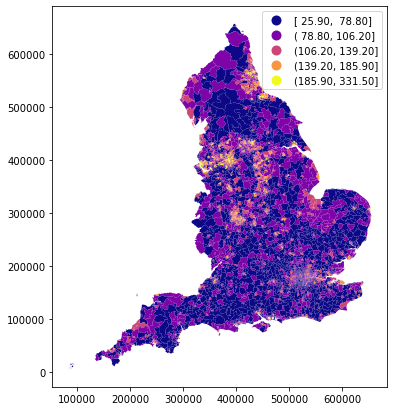

In [38]:

gdf.plot(column='preventable_deaths', cmap='plasma', 
         scheme='FisherJenks', edgecolor='None', legend=True, figsize=(9,7));

In [39]:
gdf_vars = gdf[['preventable_deaths', 'bame', 'longterm_unemployed', 'imd_2015', 'household_poverty', 'pop_0_15', 'pop_16_24', 'pop_25_64', 'pop_above_65', 'pop_above_85' ]] 

Text(0.5, 1.0, 'Correlation Matrix')

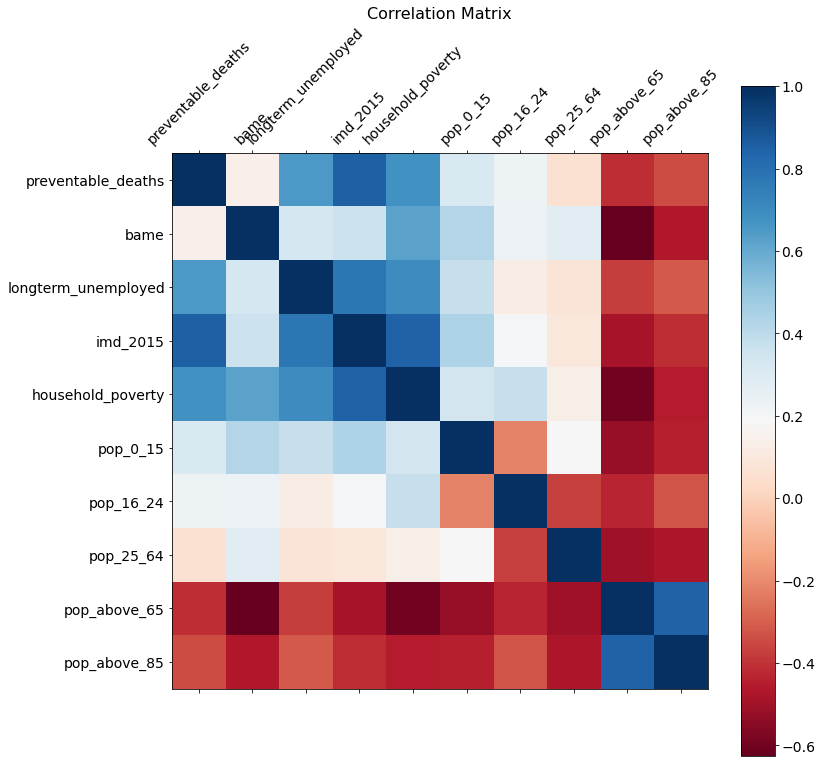

In [40]:
#plotting correlation matrix and checking for multicollinearity
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(12, 12))
plt.matshow(gdf_vars.corr(), fignum=f.number, cmap= 'RdBu')
#cmap = cm.jet
#cmaps['Perceptually Uniform Sequential'] = [ 'viridis', 'plasma', 'inferno', 'magma', 'cividis']

plt.xticks(range(gdf_vars.shape[1]), gdf_vars.columns, fontsize=14, rotation=45)
plt.yticks(range(gdf_vars.shape[1]), gdf_vars.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#plt.savefig('correlation_matrix.png', bbox_inches='tight')
#plt.matshow(corr, cmap=cm.jet)

<AxesSubplot:>

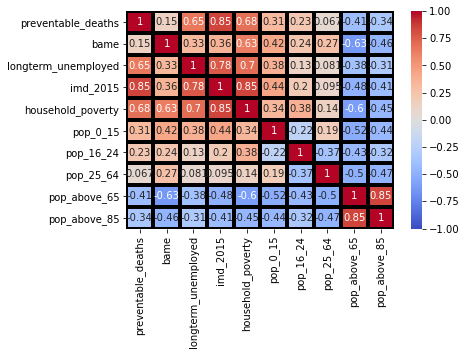

In [41]:
# trying this again with seaborn
# will make look nicer later
# code from this link:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07


sns.heatmap(gdf_vars.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')


In [42]:
#### most likely to drop pop_above_85 as we already have pop_above_65 ###

In [51]:
gdf_vars['MSOA11CD'] = gdf[['MSOA_code']]
gdf_vars = gdf_vars.fillna(0).set_index('MSOA11CD')
gdf_vars.head()

preventable_deaths  bame  longterm_unemployed  imd_2015  \
MSOA11CD                                                             
E02000001                68.5  21.4                  3.0      13.6   
E02000002                93.6  35.0                  7.3      38.5   
E02000003               101.8  45.4                  3.7      25.7   
E02000004               110.7  19.0                  7.9      24.8   
E02000005               103.9  33.7                  4.4      32.5   

           household_poverty  pop_0_15  pop_16_24  pop_25_64  pop_above_65  \
MSOA11CD                                                                     
E02000001               15.5      15.1        9.0       56.6          19.4   
E02000002               28.1      27.4       10.6       48.3          13.7   
E02000003               21.6      23.5       10.2       54.1          12.2   
E02000004               22.2      20.0       13.3       50.4          16.3   
E02000005               23.1      27.0       11.2       52.2           9.6   

           pop_above_85  
MSOA11CD                 
E02000001           2.6  
E02000002           3.0  
E02000003           1.9  
E02000004           3.4  
E02000005           1.4

In [54]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [55]:
for c in gdf_vars.columns.values:
    gdf_vars[c] = pts.fit_transform(gdf_vars[c].values.reshape(-1,1))
gdf_vars.head(3)

preventable_deaths  bame  longterm_unemployed  imd_2015  \
MSOA11CD                                                             
E02000001               -1.01  1.04                 0.31     -0.45   
E02000002               -0.06  1.36                 1.23      1.23   
E02000003                0.18  1.51                 0.53      0.55   

           household_poverty  pop_0_15  pop_16_24  pop_25_64  pop_above_65  \
MSOA11CD                                                                     
E02000001              -0.60     -1.00      -0.21       1.00          0.17   
E02000002               0.99      2.10       0.51      -0.76         -0.68   
E02000003               0.33      1.14       0.36       0.46         -0.92   

           pop_above_85  
MSOA11CD                 
E02000001          0.23  
E02000002          0.55  
E02000003         -0.41

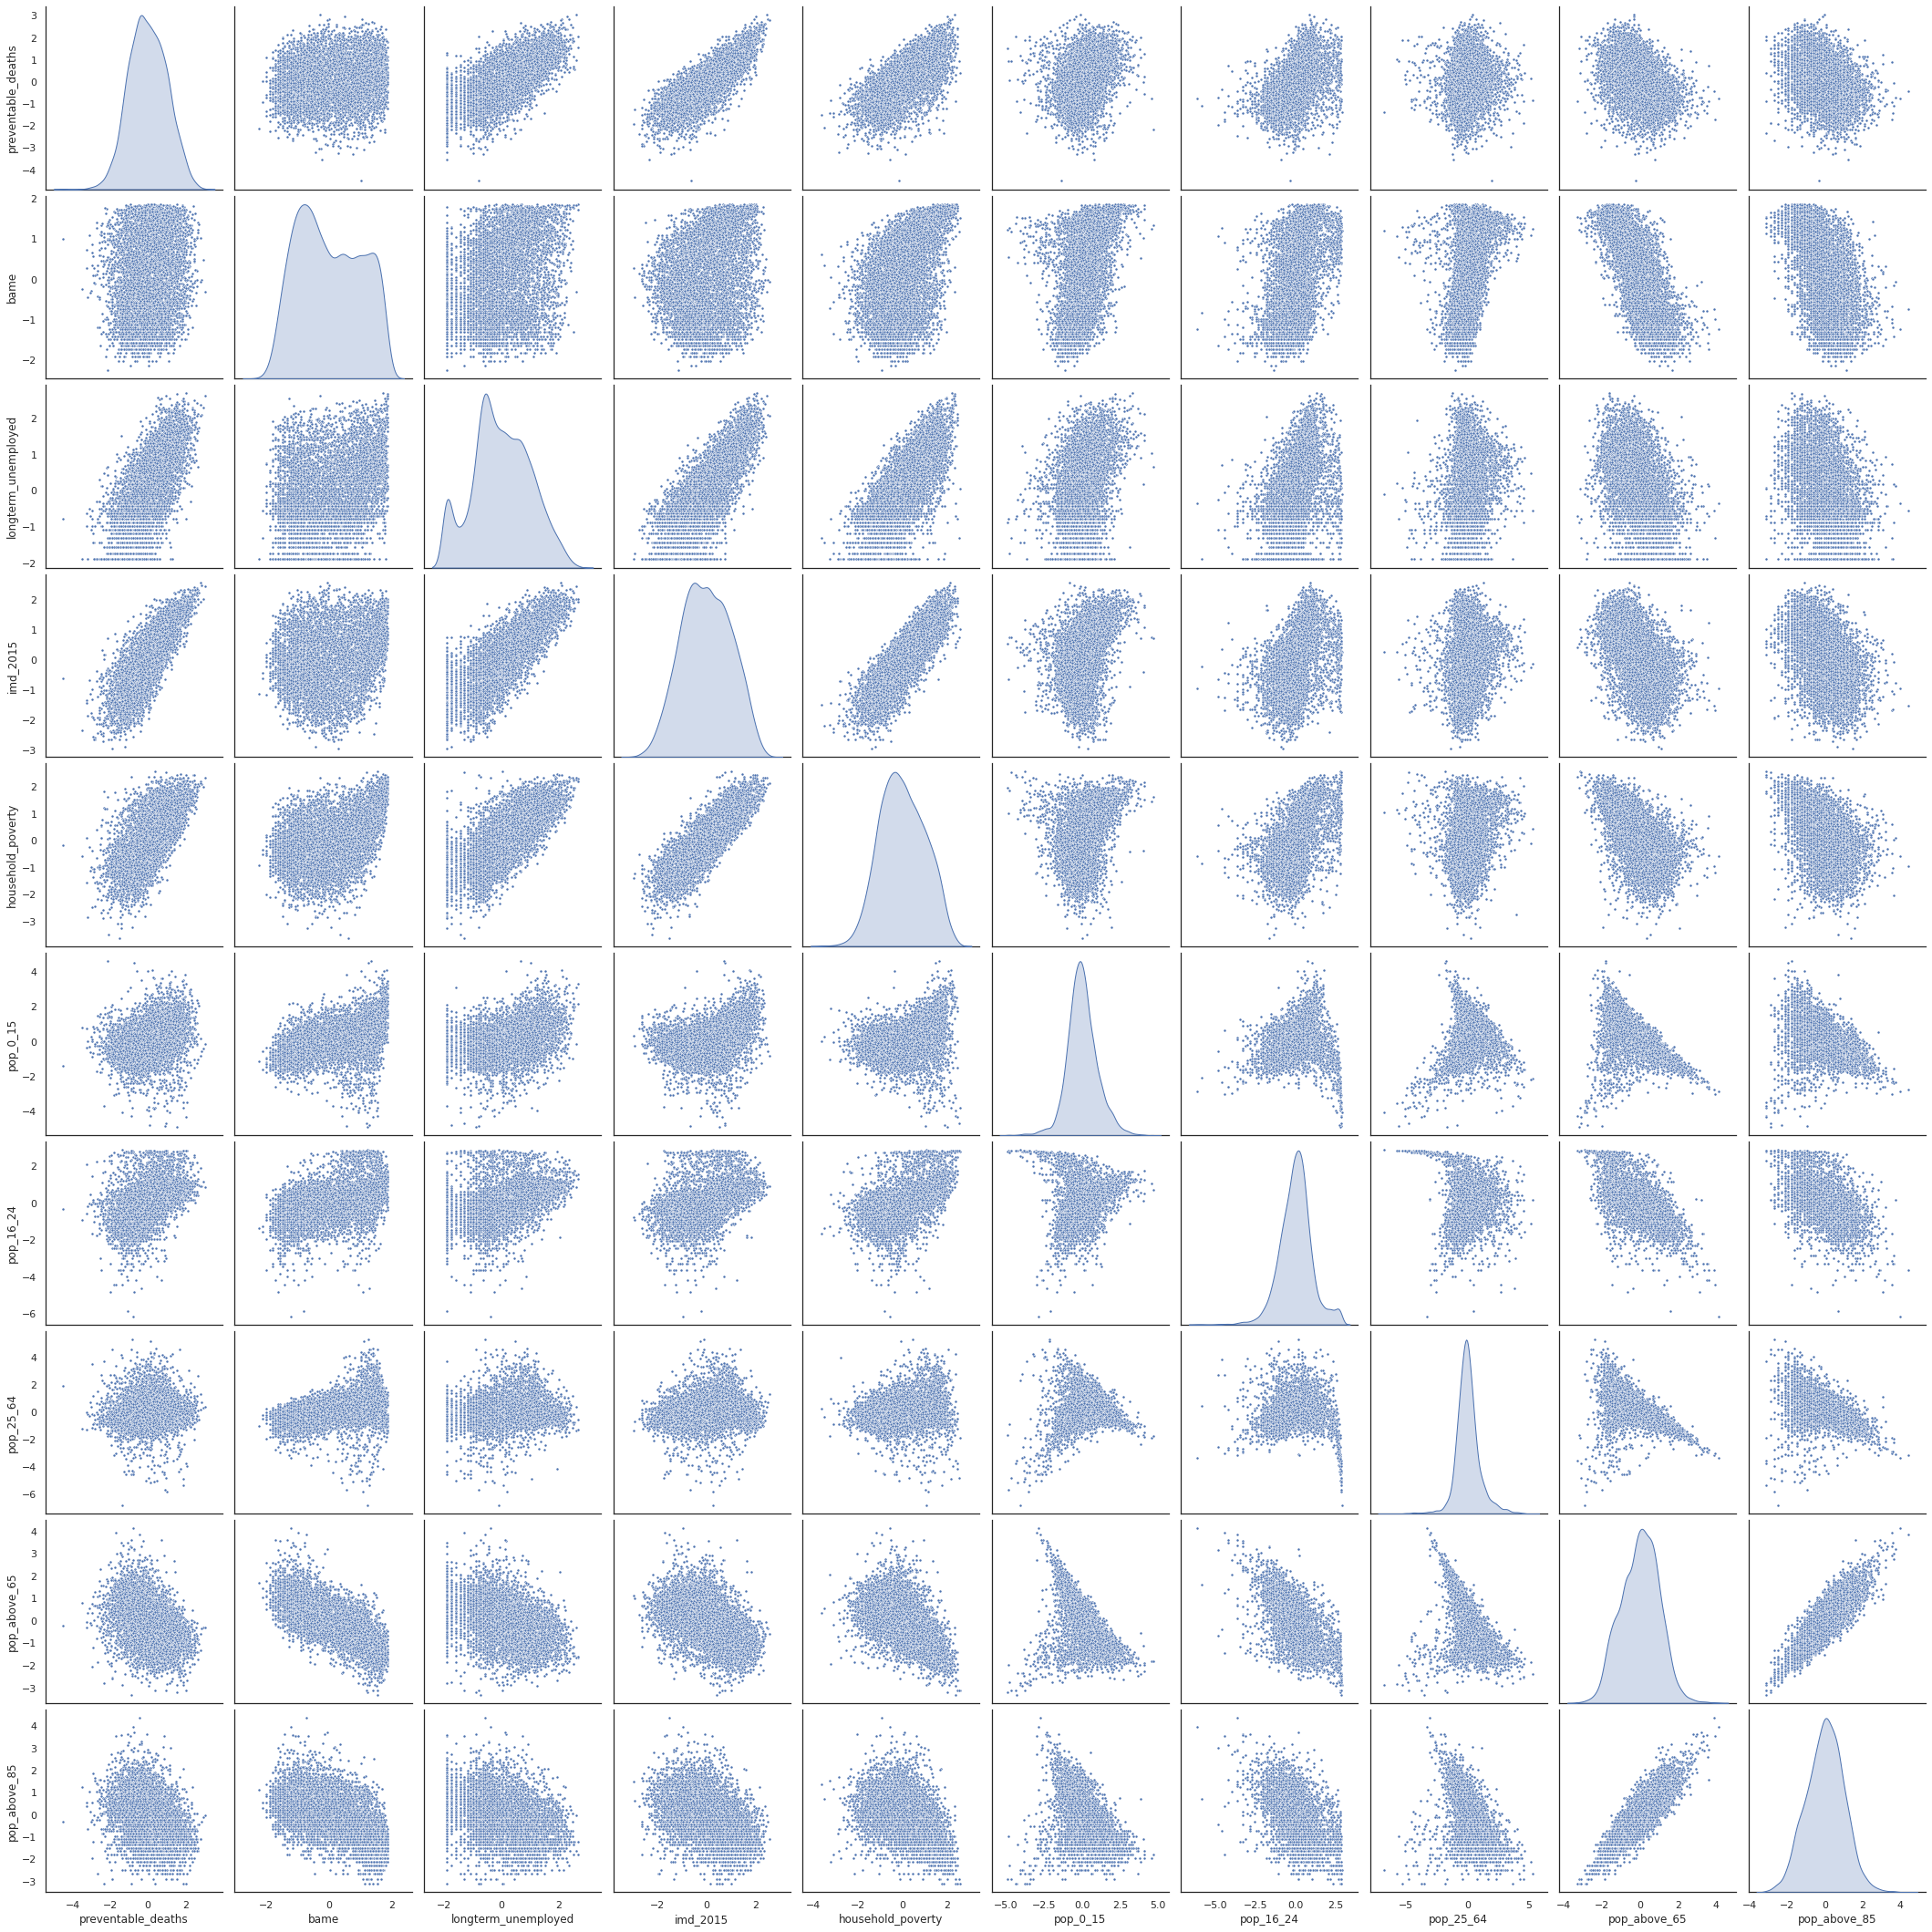

In [56]:
sns.set(style="white")
sns.pairplot(gdf_vars, markers=".", height=3, diag_kind='kde');

In [57]:
# We also create a 'result set' (rs) data frame to hold the 
# results of the clustering operation
rs   = pd.merge(msoas, gdf_vars, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

In [58]:
cols_to_plot = gdf_vars[['preventable_deaths', 'bame', 'longterm_unemployed', 'imd_2015', 'household_poverty']]
#np.random.choice(cldf.columns.values, 4, replace=False)
print(cols_to_plot)

           preventable_deaths  bame  longterm_unemployed  imd_2015  \
MSOA11CD                                                             
E02000001               -1.01  1.04                 0.31     -0.45   
E02000002               -0.06  1.36                 1.23      1.23   
E02000003                0.18  1.51                 0.53      0.55   
E02000004                0.41  0.95                 1.31      0.49   
E02000005                0.24  1.33                 0.71      0.94   
...                       ...   ...                  ...       ...   
E02006930                0.41  1.06                -0.20     -0.02   
E02006931               -0.35  1.19                 0.68      0.15   
E02006932                0.95  1.18                -1.30      0.74   
E02006933                0.34  0.93                -0.36      0.88   
E02006934                1.17  0.92                -1.43      0.42   

           household_poverty  
MSOA11CD                      
E02000001              -0.6

## First K-Means Clustering

In [69]:
c_nm   = 'KMeans' # Clustering name
k_pref = 5 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=25, random_state=42).fit(gdf_vars) # The process

print(kmeans.labels_) # The results

[3 4 1 ... 4 1 1]


Now capture the labels (i.e. clusters) and write them to a data series that we store on the result set df (`rs`):

In [70]:
# Add it to the data frame
rs[c_nm] = pd.Series(kmeans.labels_, index=gdf_vars.index)

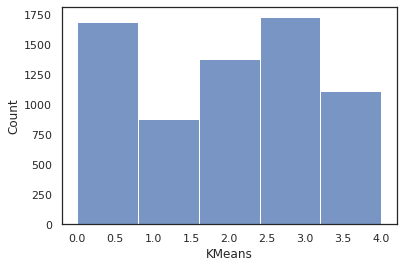

In [71]:
# How are the clusters distributed?
ax = sns.histplot(data=rs, x=c_nm, bins=k_pref);

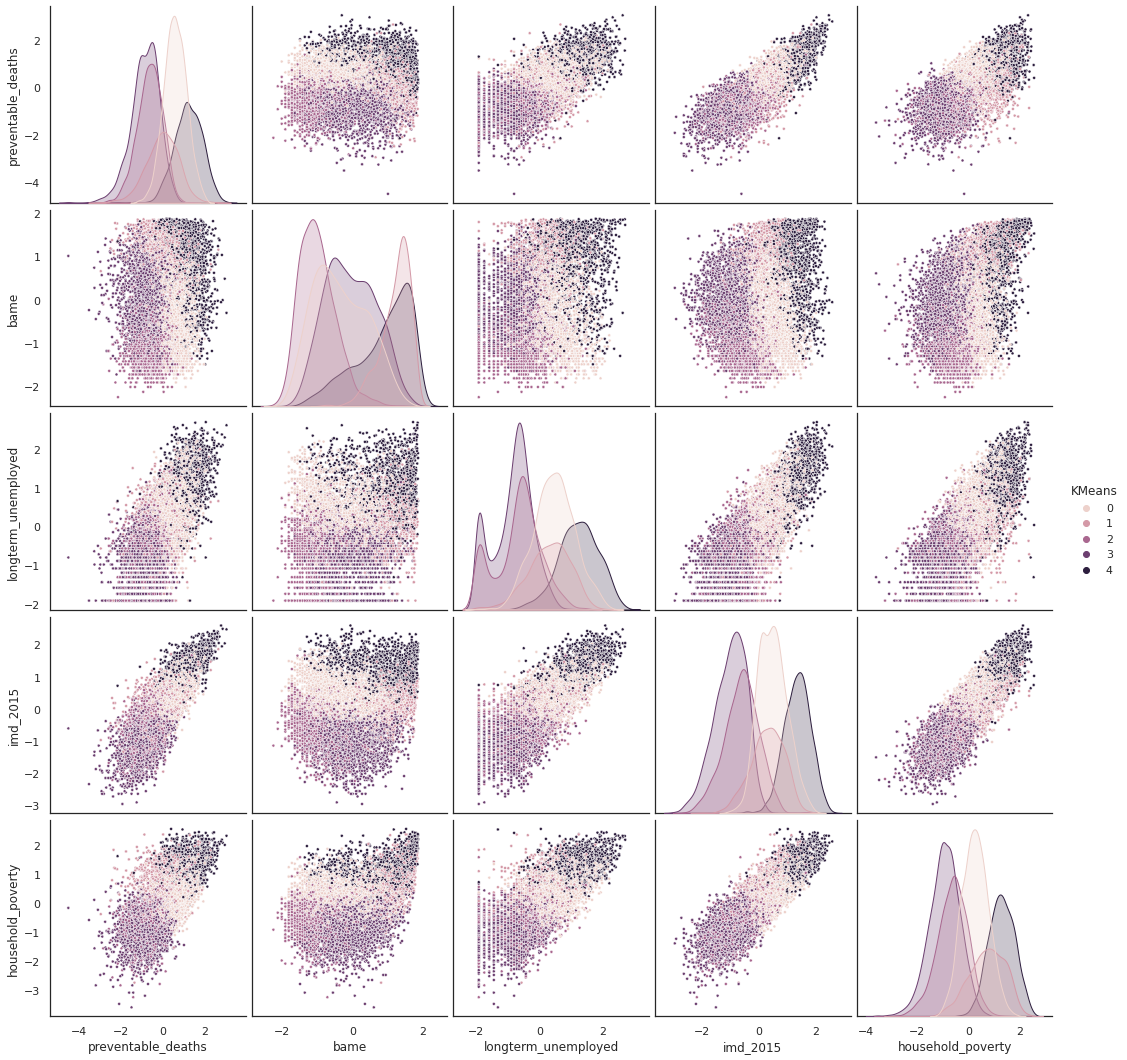

In [72]:
# Going to be a bit hard to read if 
# we plot every variable against every
# other variables, so we'll just pick a few
sns.set(style="white")
sns.pairplot(rs, 
             vars=cols_to_plot, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

And here's a map!

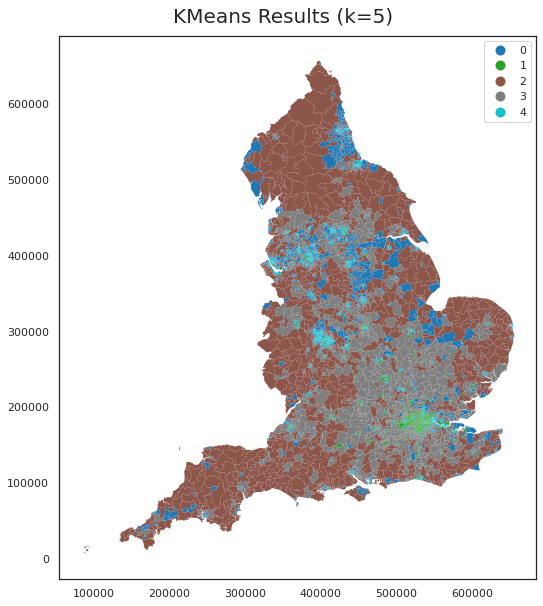

In [73]:
fig, ax = plt.subplots(figsize=(16,10))
fig.suptitle(f"{c_nm} Results (k={k_pref})", fontsize=20, y=0.92)
rs.plot(column=c_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

#### The 'Right' Number of Clusters

There's more than one way to find the 'right' number of clusters. In Singleton's _Geocomputation_ chapter they use WCSS to pick the 'optimal' number of clusters. The idea is that you plot the average WCSS for each number of possible clusters in the range of interest (2...n) and then look for a 'knee' (i.e. kink) in the curve. The principle of this approach is that you look for the point where there is declining benefit from adding more clusters. The problem is that there is always some benefit to adding more clusters (the perfect clustering is k==n), so you don't always see a knee.

Another way to try to make the process of selecting the number of clusters a little less arbitrary is called the silhouette plot and (like WCSS) it allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. In this case it's based on Partitioning Around the Medoid (PAM).

Either way, to evaluate this in a systematic way, we want to do multiple k-means clusterings for multiple values of k and then we can look at which gives the best results...

Let's try clustering across a wider range.

.......................................
Largest silhouette score was 0.3212 for k=2


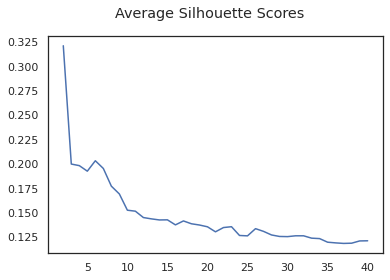

In [74]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,41):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(gdf_vars)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(gdf_vars, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");